In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
import xgboost as xgb

In [2]:
users = pd.read_csv('takehome_users.csv',
                    encoding='ISO-8859-1',
                    parse_dates=['creation_time'])
engagement = pd.read_csv('takehome_user_engagement.csv',
                         encoding='ISO-8859-1',
                         parse_dates=['time_stamp'])

In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


In [5]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [7]:
engagement.index = engagement.time_stamp
#engagement.drop(labels='time_stamp',axis=1,inplace=True)

In [8]:
engagement.head()

,time_stamp,user_id,visited
time_stamp,,,
2014-04-22 03:53:30,2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2013-12-25 03:45:04,2,1


In [9]:
#check for nulls
users.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [10]:
engagement.isnull().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

In [11]:
#fill missing values.  assuming blanks were not invited
users.invited_by_user_id = users.invited_by_user_id.fillna(0)

In [12]:
#change last session creation time to datetime.

users.last_session_creation_time = pd.to_datetime(
    users.last_session_creation_time, unit='s')

In [13]:
#last session times fill na with creation time, assuming the account was opened then not used
users.last_session_creation_time = users.last_session_creation_time.fillna(
    users.creation_time)

__Adopted Users__

In [14]:
#group user id and count.  Adopted = logged in more than 3 times over a 7 day period.


def get_rolling_count(df, freq):
    return df.rolling(freq, on='time_stamp')['visited'].count()


engagement['visited_7D'] = engagement.groupby('user_id',
                                              as_index=False,
                                              group_keys=False).apply(
                                                  get_rolling_count, freq='7D')

In [15]:
engagement.head()

,time_stamp,user_id,visited,visited_7D
time_stamp,,,,
2014-04-22 03:53:30,2014-04-22 03:53:30,1,1,1.0
2013-11-15 03:45:04,2013-11-15 03:45:04,2,1,1.0
2013-11-29 03:45:04,2013-11-29 03:45:04,2,1,1.0
2013-12-09 03:45:04,2013-12-09 03:45:04,2,1,1.0
2013-12-25 03:45:04,2013-12-25 03:45:04,2,1,1.0


In [16]:
adopted = engagement.loc[(engagement.visited_7D >= 3)]
adopted = adopted.drop_duplicates('user_id', keep='first')

In [17]:
adopted_id = adopted.user_id.tolist()

In [18]:
#pass in adopted list as int
users['adopted'] = users['object_id'].isin(adopted_id).astype('int')

In [19]:
#adopted users is 1602
users.adopted.value_counts()

0    10398
1     1602
Name: adopted, dtype: int64

In [20]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  12000 non-null  datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  float64       
 10  adopted                     12000 non-null  int32         
dtypes: datetime64[ns](2), float64(1), int32(1), int64(4), 

In [21]:
#417 unique org ids.  Try to see which orgs are responsible for the most adopted users.
users.org_id.nunique()

417

In [22]:
users.name.nunique()

11355

In [23]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


ORG_INVITE            0.354500
GUEST_INVITE          0.180250
PERSONAL_PROJECTS     0.175917
SIGNUP                0.173917
SIGNUP_GOOGLE_AUTH    0.115417
Name: creation_source, dtype: float64

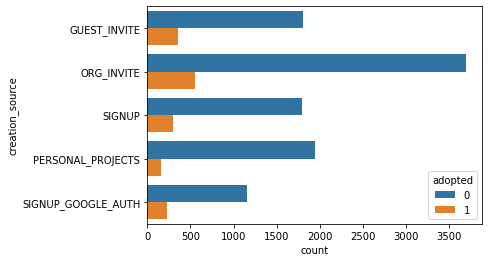

In [24]:
#explore creation source to see where adopted users are coming from.
sns.countplot(
    data=users,
    y='creation_source',
    hue='adopted',
)
users.creation_source.value_counts(1)

In [25]:
#most are coming from org invites or guest invites.  org invites is the largest contributor
#looks like room for growth in personal projects.  has the lowest ratio of adopted

In [26]:
users1 = users.drop([
    'object_id', 'name', 'email', 'last_session_creation_time', 'creation_time','org_id',
],
                   axis=1)

usersdum = pd.get_dummies(users1)



In [27]:
usersdum.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,adopted,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,10803.0,0,1,0,0,0,0
1,0,0,316.0,1,0,1,0,0,0
2,0,0,1525.0,0,0,1,0,0,0
3,0,0,5151.0,0,1,0,0,0,0
4,0,0,5240.0,0,1,0,0,0,0


In [28]:
#split data

X = usersdum.drop('adopted', axis=1)
y = usersdum.adopted

In [29]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.75,
    random_state=123,
)

In [30]:
xgbcl = xgb.XGBClassifier(objective='binary:logistic',
                          tree_method='gpu_hist',
                          n_jobs=-1,
                          random_state=123)

# Fit the classifier to the training set
xgbcl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0)', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [31]:
# Predict the labels of the test set: preds
y_pred = xgbcl.predict(X_test)

# Compute the accuracy: accuracy
accuracy = float(np.sum(y_pred == y_test)) / y_test.shape[0]
print("accuracy: %f" % (accuracy))

accuracy: 0.851556


In [32]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[7628  182]
 [1154   36]]
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      7810
           1       0.17      0.03      0.05      1190

    accuracy                           0.85      9000
   macro avg       0.52      0.50      0.49      9000
weighted avg       0.78      0.85      0.80      9000



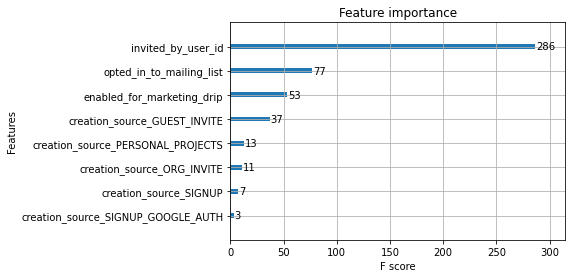

In [33]:
#What are the most important features in the dataset
dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {
    "objective": "binary:logistic",
    'tree_method': 'gpu_hist',
    'n_jobs': -1
}

# Train the model:
xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=20)

# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.show()

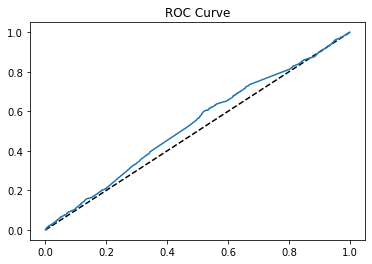

In [34]:
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
# Compute predicted probabilities: y_pred_prob
y_pred_prob = xgbcl.predict_proba(X_test)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.show()

In [35]:
#create potential features based on time

#users['account_age'] = max(users['creation_time']) - users['creation_time']
#users['account_age'] = users['account_age'].dt.days

In [36]:
#could create features based on 

In [37]:
#users.org_id = users.org_id.astype('int')
#users.adopted = users.adopted.astype('boolean')

In [38]:
data, data_unseen = train_test_split(users1, train_size=0.8, random_state=42)

In [39]:
clf_setup = setup(
    data=data,
    target='adopted',
)

,Description,Value
0,session_id,7912
1,Target,adopted
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(9600, 5)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [40]:
compare = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8662,0.5547,0.0000,0.0000,0.0000,0.0000,0.0000,0.4740
nb,Naive Bayes,0.8662,0.5698,0.0000,0.0000,0.0000,0.0000,0.0000,0.0120
ridge,Ridge Classifier,0.8662,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0140
lda,Linear Discriminant Analysis,0.8662,0.5654,0.0000,0.0000,0.0000,0.0000,0.0000,0.0150
ada,Ada Boost Classifier,0.8661,0.5528,0.0000,0.0000,0.0000,-0.0003,-0.0015,0.0760
catboost,CatBoost Classifier,0.8655,0.5474,0.0022,0.0833,0.0043,0.0017,0.0056,3.0860
gbc,Gradient Boosting Classifier,0.8649,0.5542,0.0011,0.0333,0.0022,-0.0010,-0.0035,0.0990
lightgbm,Light Gradient Boosting Machine,0.8644,0.5485,0.0011,0.0500,0.0022,-0.0019,-0.0056,0.0490
xgboost,Extreme Gradient Boosting,0.8600,0.5426,0.0033,0.0767,0.0063,-0.0072,-0.0157,0.4630
et,Extra Trees Classifier,0.8187,0.5151,0.0689,0.1396,0.0917,0.0043,0.0046,0.2300


In [41]:
lgbm = create_model('lgbm')

ValueError: Estimator lgbm not available. Please see docstring for list of available estimators.

In [ ]:
plot_model(lgbm, plot="confusion_matrix")

In [ ]:
plot_model(lgbm, plot='feature')